In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

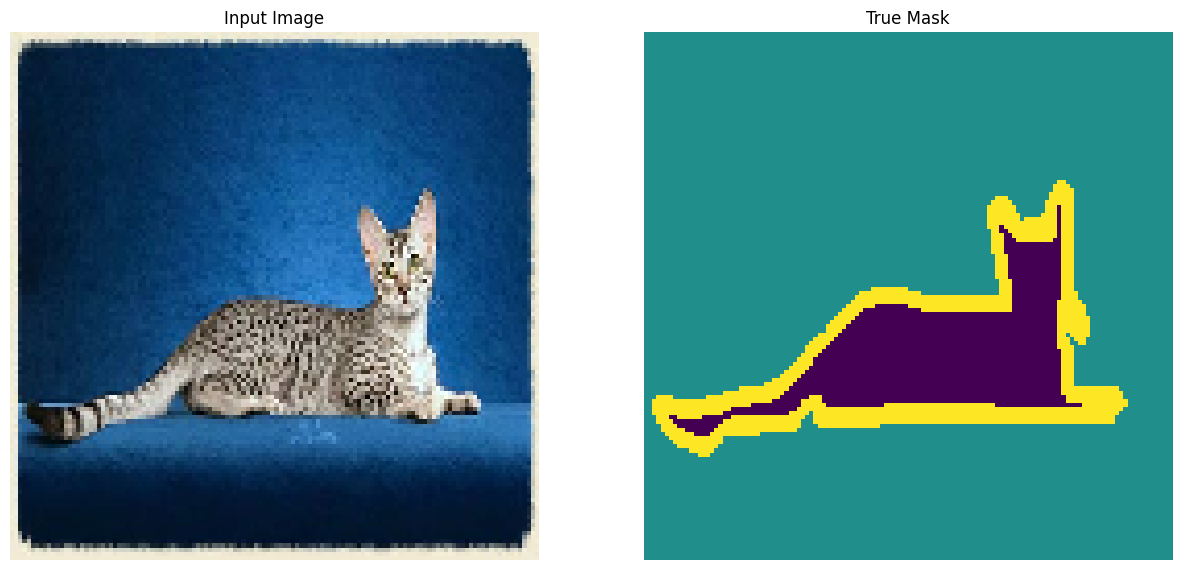

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x



In [ ]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
unet_model = build_unet_model()

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.5834 - loss: 0.9938 - val_accuracy: 0.7105 - val_loss: 0.7333
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7017 - loss: 0.7389 - val_accuracy: 0.7267 - val_loss: 0.6690
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7353 - loss: 0.6494 - val_accuracy: 0.7318 - val_loss: 0.6361
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7513 - loss: 0.6141 - val_accuracy: 0.7855 - val_loss: 0.5398
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7852 - loss: 0.5418 - val_accuracy: 0.7956 - val_loss: 0.5174
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8011 - loss: 0.5071 - val_accuracy: 0.8236 - val_loss: 0.4444
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8236 - loss: 0.4522 - val_accuracy: 0.8429 - val_loss: 0.4047
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8380 - loss: 0.4211 - val_accuracy: 0.8458 - val_los

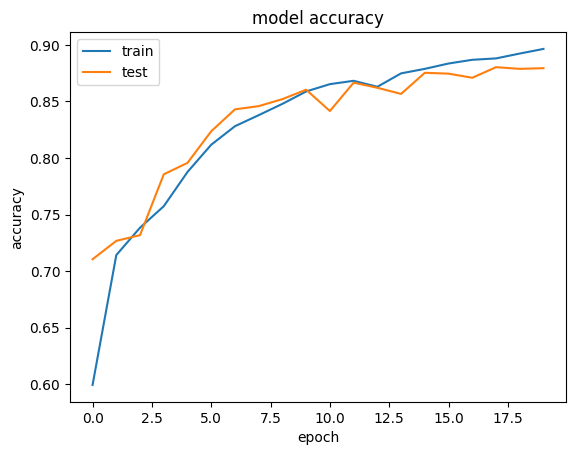

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])


NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

# plot the history graphs
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
# Save the trained U-Net model
unet_model.save('unet_pet_segmentation_model.keras')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
#load saved model
unet_model = tf.keras.models.load_model('unet_pet_segmentation_model.keras')


def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def preprocess_and_predict(image_path, model):
  """
  Loads, preprocesses, and predicts the segmentation mask for an image.

  Args:
    image_path: The path to the image file.
    model: The trained U-Net model.

  Returns:
    The raw prediction output from the model.
  """
  # Load the image
  uploaded_image = cv2.imread(image_path)

  # Check if the image was loaded successfully
  if uploaded_image is None:
    print(f"Error: Could not load image from path: {image_path}")
    return None # Return None or raise an error

  # Convert the image to RGB (OpenCV reads in BGR)
  uploaded_image = cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2RGB)

  # Resize the image
  resized_image = tf.image.resize(uploaded_image, (128, 128), method="nearest")

  # Normalize the image (similar to the normalize function used for the dataset)
  normalized_image = tf.cast(resized_image, tf.float32) / 255.0

  # Add a batch dimension
  input_image = tf.expand_dims(normalized_image, axis=0)

  # Use the predict_mask function to get the prediction
  predicted_mask_output = model.predict(input_image)
  display([input_image[0], create_mask(predicted_mask_output)])
  print(predicted_mask_output.shape)

  #return predicted_mask_output

# Example usage (assuming 'unet_model' is your loaded or defined U-Net model
# and 'image_filename' is the path to your uploaded image):
# predicted_mask_output = preprocess_and_predict(image_filename, unet_model)
# print("Preprocessing and prediction complete.")
# print(f"Shape of predicted mask output: {predicted_mask_output.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


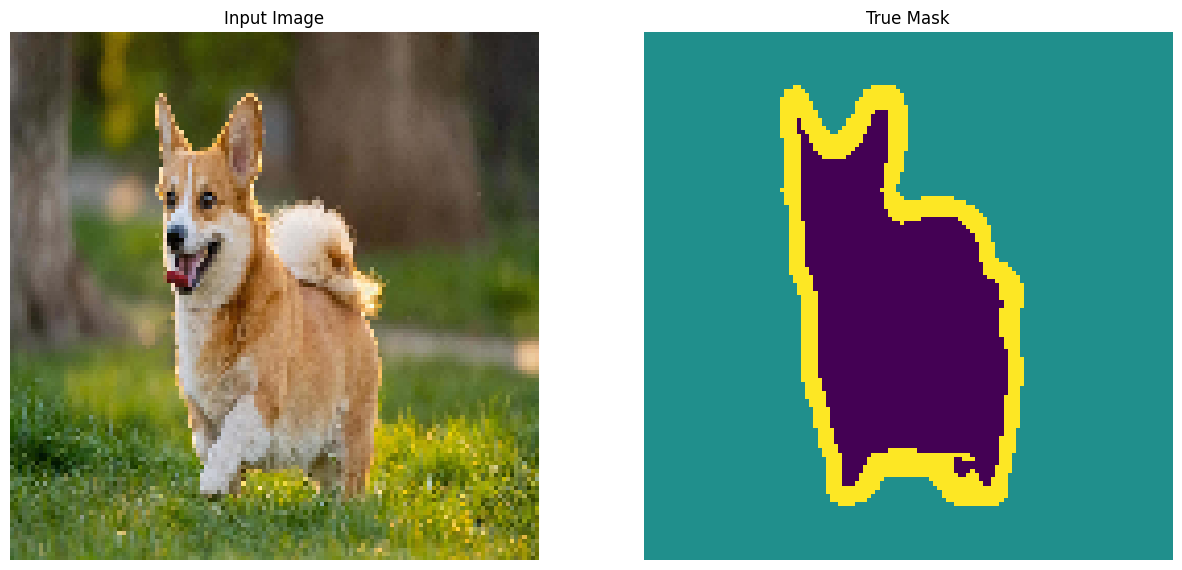

(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


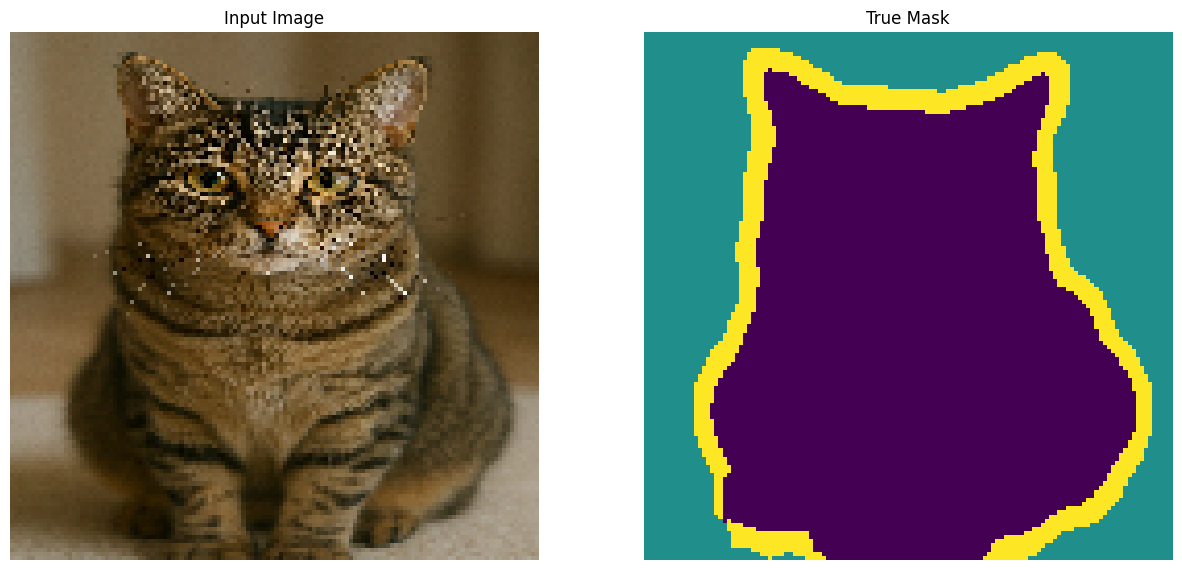

(1, 128, 128, 3)


In [ ]:
preprocess_and_predict('unet_dog.jpeg', unet_model)
preprocess_and_predict('unet_cat.png', unet_model)

In [ ]:
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_images_from_folder(folder_path, max_images=1):
    images = []
    filenames = os.listdir(folder_path)

    for file in filenames[:max_images]:
        file_path = os.path.join(folder_path, file)

        # Open image, resize, normalize
        img = Image.open(file_path).convert('RGB').resize((128, 128))
        img_array = np.array(img) / 255.0
        images.append(img_array)

    return np.array(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


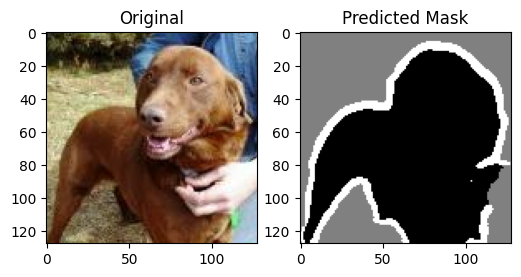

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


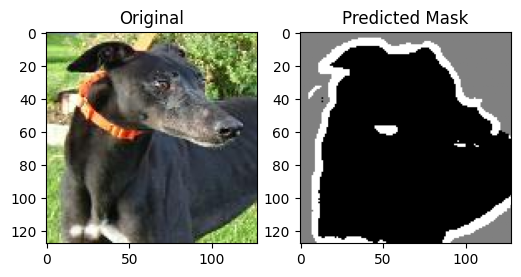

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


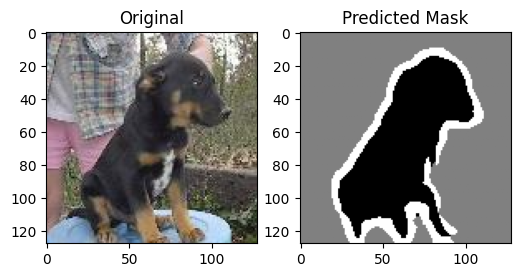

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


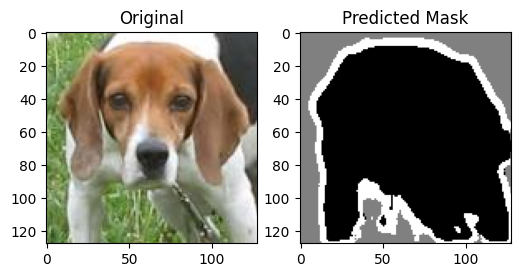

In [ ]:
# Load images of dogs.
images = load_images_from_folder("pics")

# Predict masks for each
for img in images:
    img_input = np.expand_dims(img, axis=0)  # add batch dimension
    pred = unet_model.predict(img_input)[0]

    if pred.shape[-1] > 1:
        pred = np.argmax(pred, axis=-1)
    else:
        pred = pred.squeeze()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.show()

    # take the mask and extract just the dog from the picture
    plt.subplot(1, 2, 3)





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


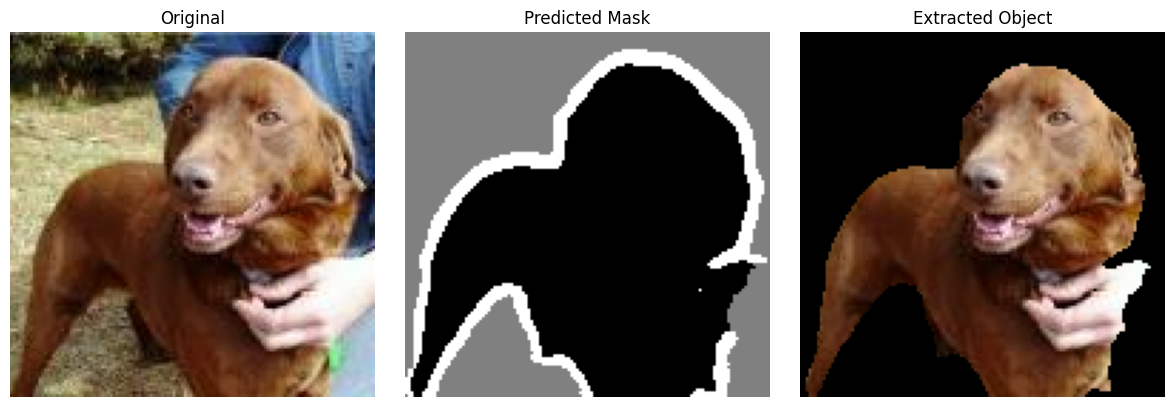

In [ ]:
# Load images of dogs.
images = load_images_from_folder("pics")

# Predict masks for each
for img in images:
    img_input = np.expand_dims(img, axis=0)  # Add batch dimension
    pred = unet_model.predict(img_input)[0]  # Predict mask

    # Post-process prediction
    if pred.shape[-1] > 1:
        pred = np.argmax(pred, axis=-1)
    else:
        pred = pred.squeeze()

    # Convert mask to 3-channel to apply to RGB image
    mask = np.logical_not(pred).astype(np.uint8)  # Invert mask: dog=1, background=0
    mask_3ch = np.stack([mask]*3, axis=-1)

    # Extract object using mask
    extracted = img * mask_3ch

    # Plot everything
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(extracted)
    plt.title("Extracted Object")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_images_from_folder(folder_path, max_images=None):
    from PIL import Image
    image_list = []
    for i, filename in enumerate(sorted(os.listdir(folder_path))):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB").resize((128, 128))
            img_array = np.array(img) / 255.0
            image_list.append(img_array)
        if max_images and len(image_list) >= max_images:
            break
    return image_list

# Load images
images = load_images_from_folder("cat_dog_mix")
num_images = len(images)

# Store results
pred_masks = []
extracted_images = []

for img in images:
    img_input = np.expand_dims(img, axis=0)
    pred = unet_model.predict(img_input, verbose=0)[0]

    # Get binary mask
    if pred.shape[-1] > 1:
        mask = np.argmax(pred, axis=-1)
    else:
        mask = (pred.squeeze() > 0.5).astype(np.uint8)

    # Optional: Invert if needed
    mask = np.logical_not(mask).astype(np.uint8)

    # Create 3-channel mask and extract
    mask_3ch = np.stack([mask] * 3, axis=-1)
    extracted = img * mask_3ch

    pred_masks.append(mask)
    extracted_images.append(extracted)

# Plot everything in a grid
fig, axs = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))

# Fix 1D edge case
if num_images == 1:
    axs = np.expand_dims(axs, axis=0)

for i in range(num_images):
    axs[i, 0].imshow(images[i])
    axs[i, 0].set_title(f"Original {i+1}")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(pred_masks[i], cmap="gray")
    axs[i, 1].set_title(f"Predicted Mask {i+1}")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(extracted_images[i])
    axs[i, 2].set_title(f"Extracted {i+1}")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()